In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

Global seed set to 0


# Read data from cellrank package

In [2]:
adata = cr.datasets.pancreas()

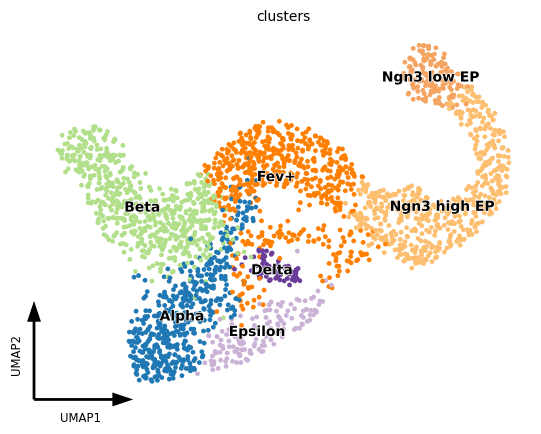

In [3]:
scv.pl.umap(adata, color='clusters', frameon='artist')

# Setup data and train model

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.standard_clean_recipe(adata)

Filtered out 22024 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.VAE(observed=2000, latent_dim=20, zr_dim=2, h_dim=2)

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='pancreas_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
910 velocity genes used


/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/dataloader.py:41: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


epoch 0, full loss 232.676, val loss 187.341, recon MSE 4.951, traj MSE 1.267, corr reg -2.245
epoch 1, full loss 142.122, val loss 101.289, recon MSE 4.355, traj MSE 1.120, corr reg -2.410
epoch 2, full loss 70.873, val loss 32.357, recon MSE 3.948, traj MSE 1.113, corr reg -2.468
epoch 3, full loss 2.308, val loss -40.903, recon MSE 2.966, traj MSE 0.997, corr reg -2.429
epoch 4, full loss -58.256, val loss -111.040, recon MSE 2.072, traj MSE 0.827, corr reg -1.749
epoch 5, full loss -113.592, val loss -185.139, recon MSE 1.800, traj MSE 0.763, corr reg -2.245
epoch 6, full loss -153.937, val loss -258.986, recon MSE 1.631, traj MSE 0.731, corr reg -2.340
epoch 7, full loss -175.162, val loss -324.687, recon MSE 1.765, traj MSE 0.762, corr reg -1.727
epoch 8, full loss -208.892, val loss -371.576, recon MSE 1.401, traj MSE 0.665, corr reg -1.430
epoch 9, full loss -225.312, val loss -412.710, recon MSE 1.334, traj MSE 0.667, corr reg -1.116
epoch 10, full loss -234.281, val loss -449

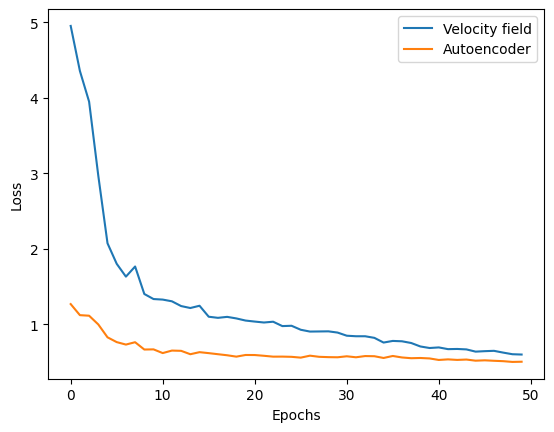

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute and plot velocity on UMAP

In [8]:
latent_adata = ltv.output_results(model, adata)

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


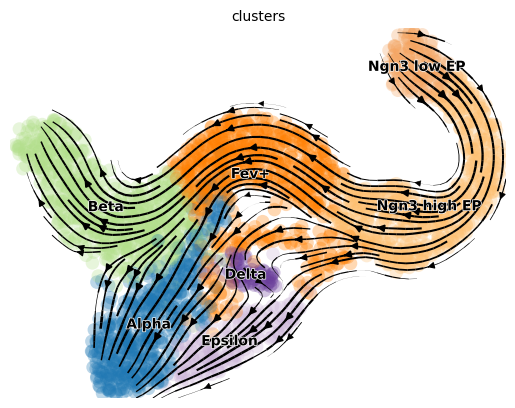

In [10]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity')

# Compute CBDir transition scores

In [11]:
pancreas_edges = [
    ('Ngn3 low EP', 'Ngn3 high EP'), 
    ('Ngn3 high EP', 'Fev+'),
    ('Fev+', 'Delta'), 
    ('Fev+', 'Beta'), ('Fev+','Epsilon'), ('Fev+','Alpha')]

In [12]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
pancreas_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'clusters', 'spliced_velocity_pca', pancreas_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


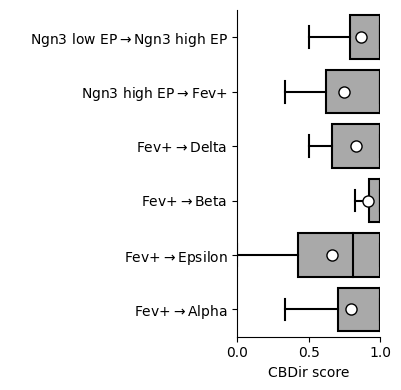

In [13]:
ax=ltv.pl.transition_scores(pancreas_pca, raw=True)
ax.set(xlim=(0,1))
plt.show()

# Plot z_r scatter and compute lineage classification accuracy from z_r

Renamed 'zr' to convention 'X_zr' (adata.obsm).


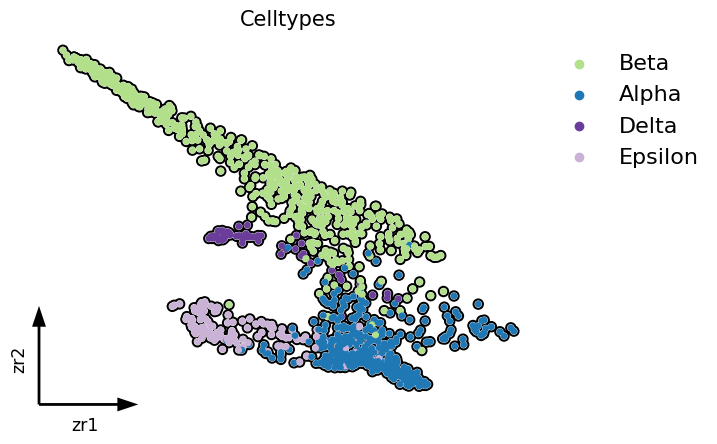

In [14]:
scv.pl.scatter(latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])],
               'zr', color='clusters', frameon='artist', title='Celltypes', fontsize=15,
              legend_fontsize=16, add_outline=True)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

clf = LogisticRegression(penalty='none', max_iter=1e4)

data_= latent_adata[latent_adata.obs['clusters'].isin(['Epsilon', 'Alpha', 'Beta', 'Delta'])].copy()

X = data_.obsm['zr']
y = LabelEncoder().fit_transform(data_.obs['clusters'].values)


pancreas_cvs = cross_val_score(clf, X, y, cv=25)

In [16]:
print('Prediction accuracy (2.5, 50, 97.5) percentiles:', np.percentile(pancreas_cvs, q=[2.5,50,97.5]))

Prediction accuracy (2.5, 50, 97.5) percentiles: [0.8745098  0.94117647 0.98846154]


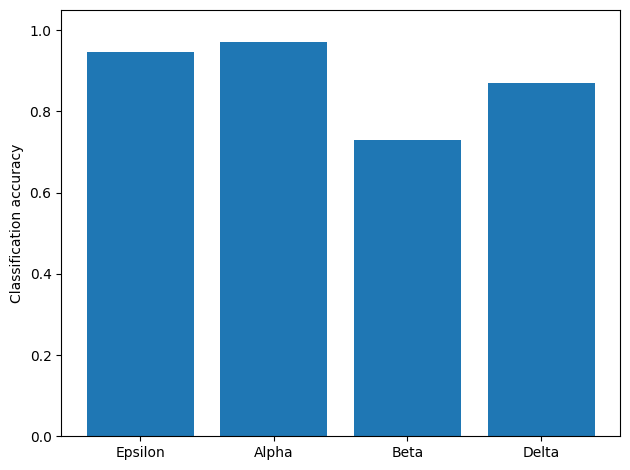

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
clf.fit(X, y)
pred = clf.predict(X)
class_accuracy = confusion_matrix(y, pred, normalize="true").diagonal()

fig, ax = plt.subplots()

plt.bar(x=['Epsilon', 'Alpha', 'Beta', 'Delta'],height=class_accuracy)

ax.set(ylim=(0,1.05))
ax.set(ylabel='Classification accuracy')
plt.tight_layout()
plt.show()

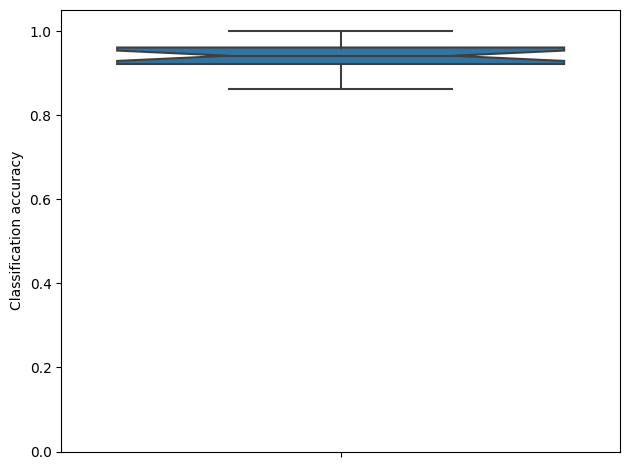

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.boxplot(y=pancreas_cvs, ax=ax, notch=True)

ax.set(ylim=(0,1.05))
ax.set(ylabel='Classification accuracy')
plt.tight_layout()
plt.show()